In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#load PM2.5 data from 2018~2020
x_train, y_train = np.load("train_x.npy"), np.load("train_y.npy")
x_test, y_test = np.load("test_x.npy"), np.load("test_y.npy")
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

(19257, 24) (19257, 1) (4815, 24) (4815, 1)


In [3]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

(19257, 24, 1) (19257, 1) (4815, 24, 1) (4815, 1)


In [4]:
#make 1d-CNN
#filter: the dimensionality of the output space 
#.      (i.e. the number of output filters in the convolution)
#kernel_size: specifying the length of the 1D convolution window.
#strides: Specifying the stride length of the convolution. 
cnn = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', input_shape=(24,1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, activation='relu'),
    layers.Conv1D(filters=256, kernel_size=10, strides=1, activation='sigmoid'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

2021-09-19 17:18:12.125892: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 17:18:12.126318: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [6]:
#Once the model is created, you can config the model with losses and metrics
#with model.compile(), 
#train the model with model.fit(), 
#or use the model to do prediction with model.predict().
cnn.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [7]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 128)           41088     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 256)            327936    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 256)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [8]:
#let's do whether model works okay
example_batch = x_train[0:2]
example_result = cnn.predict(example_batch)

In [9]:
example_result
print(np.shape(x_train[0:2]), np.shape(example_result))

(2, 24, 1) (2, 1)


In [10]:
#Let's do training with model.fit
EPOCHS = 1000
history = cnn.fit(
  x_train, y_train,
  epochs=EPOCHS, validation_split = 0.1, verbose=1)

Train on 17331 samples, validate on 1926 samples
Epoch 1/1000
17331/17331 [==============================] - 15s 876us/sample - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/1000
17331/17331 [==============================] - 14s 809us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/1000
17331/17331 [==============================] - 14s 827us/sample - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/1000
17331/17331 [==============================] - 15s 842us/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/1000
17331/17331 [==============================] - 15s 853us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/1000
17331/17331 [==============================] - 14s 798us/sample - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/1000
17331/17331 [==============================] - 15s 840us/sample - loss: 0.0030 -

In [11]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
995,0.000672,0.000672,0.001157,0.001157,995
996,0.000664,0.000664,0.001171,0.001171,996
997,0.000672,0.000672,0.001180,0.001180,997
998,0.000659,0.000659,0.001166,0.001166,998
999,0.000665,0.000665,0.001174,0.001174,999


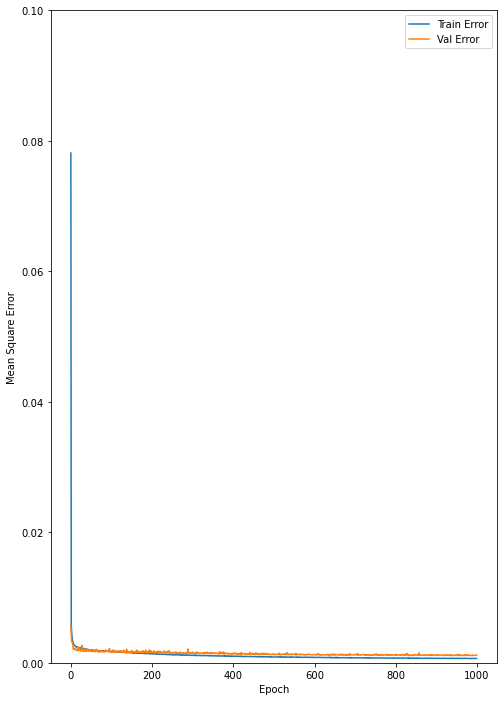

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.1])
  plt.legend()
  plt.show()

plot_history(history)

In [14]:
test_predictions = cnn.predict(x_test).flatten()
print(np.shape(y_test), np.shape(test_predictions))

(4815, 1) (4815,)


In [15]:
#Evaluate with test set
loss,  mse = cnn.evaluate(x_test, y_test, verbose=2)
pm25_max = 149.0
pm25_min = 1.0
mse = mse*(pm25_max-pm25_min) + pm25_min
print("MSE of testset: {:5.2f} ug/m^3".format(mse))

4815/1 - 3s - loss: 8.2415e-04 - mse: 0.0011
MSE of testset:  1.17 ug/m^3


In [16]:
#de-normalization
for i in range(len(y_test)):
    y_test[i,0] = y_test[i,0]*(pm25_max-pm25_min)+pm25_min
    test_predictions[i] = test_predictions[i]*(pm25_max-pm25_min)+pm25_min

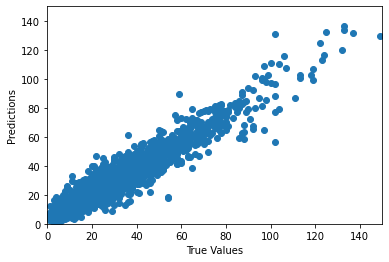

In [17]:
#plot results
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim([0,150])
plt.xlim([0,150])
plt.show()

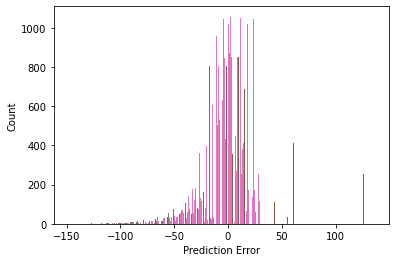

In [18]:
error = test_predictions - y_test
plt.hist(error, 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")